In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

In [6]:
df = pd.read_csv("../data/processed/crop_data_pivot.csv")

In [7]:
# Define targets and features
elements = ["Production", "Area harvested", "Yield"]
#features = ["Year"]  # These should be the actual feature columns used


📌 Evaluating Models for: Production
🔍 Evaluating: ANN
3599/3599 ━━━━━━━━━━━━━━━━━━━━ 3s 656us/step
✅ MSE: 381291594584696.81 | R²: 0.37


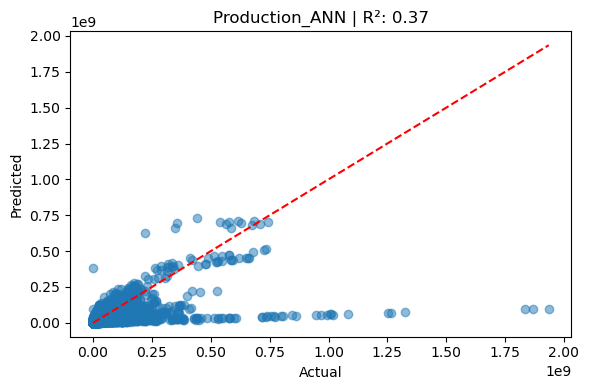

🔍 Evaluating: RandomForest


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


✅ MSE: 384483020708.52 | R²: 1.00


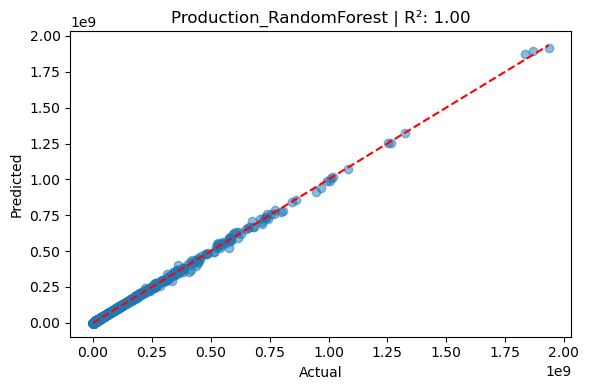

🔍 Evaluating: LinearRegression


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


✅ MSE: 390505043754082.00 | R²: 0.35


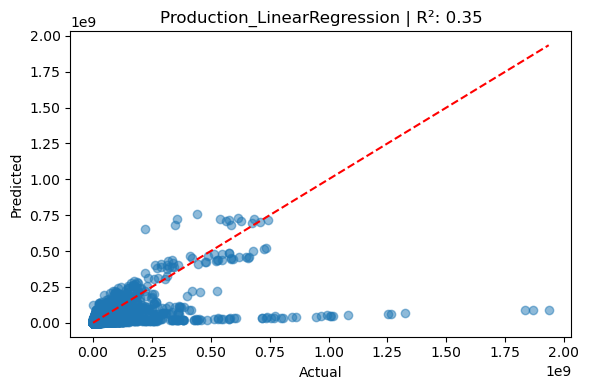

🔍 Evaluating: XGBoost
✅ MSE: 51349833633528.82 | R²: 0.91


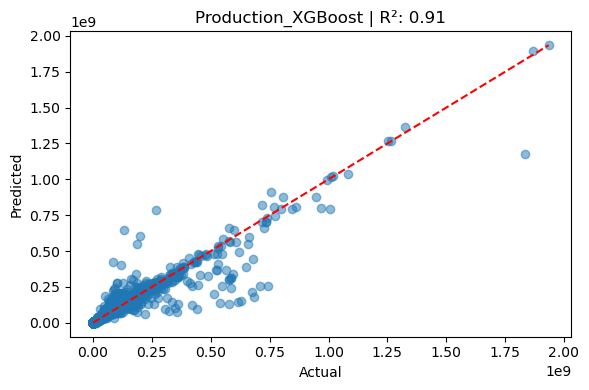


📌 Evaluating Models for: Area harvested
🔍 Evaluating: ANN
3599/3599 ━━━━━━━━━━━━━━━━━━━━ 2s 528us/step
✅ MSE: 5645392524469.07 | R²: 0.74


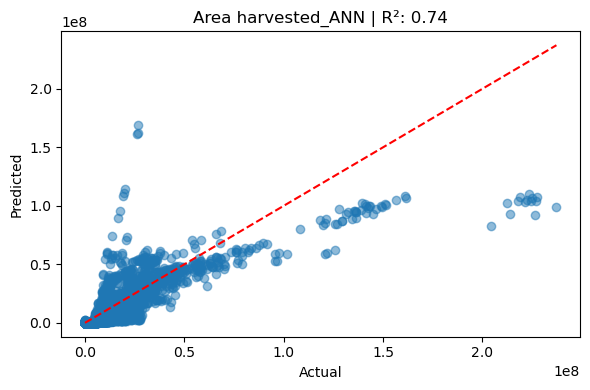

🔍 Evaluating: RandomForest


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


✅ MSE: 19610786296.41 | R²: 1.00


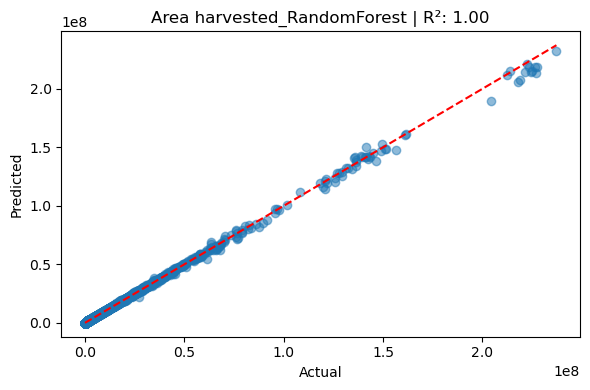

🔍 Evaluating: LinearRegression


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


✅ MSE: 13908006655718.41 | R²: 0.35


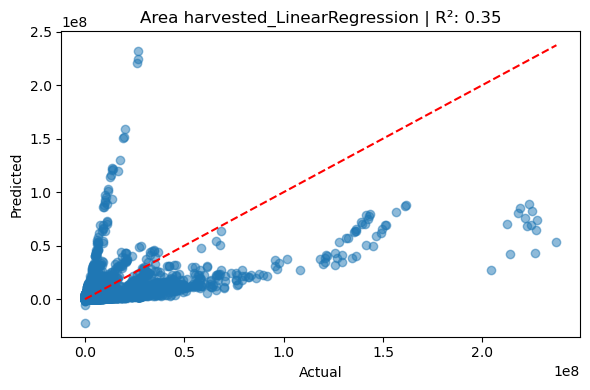

🔍 Evaluating: XGBoost
✅ MSE: 3619417522834.73 | R²: 0.83


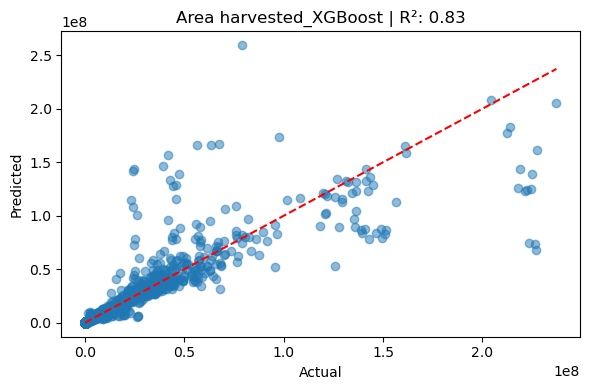


📌 Evaluating Models for: Yield
🔍 Evaluating: ANN
3599/3599 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step
✅ MSE: 12605826517219.78 | R²: 0.00


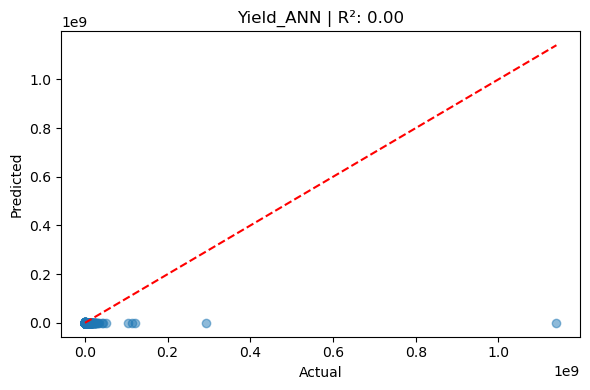

🔍 Evaluating: RandomForest


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


✅ MSE: 2792388796084.89 | R²: 0.78


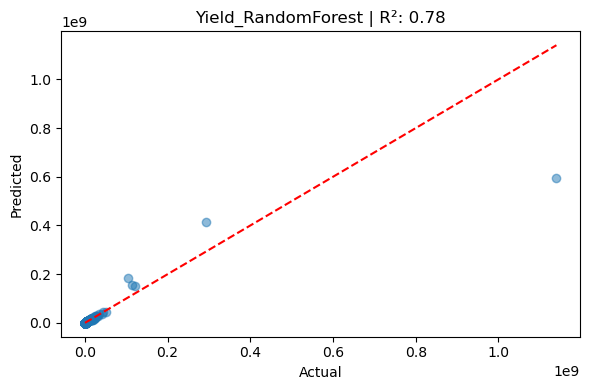

🔍 Evaluating: LinearRegression


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


✅ MSE: 12607073523597.91 | R²: 0.00


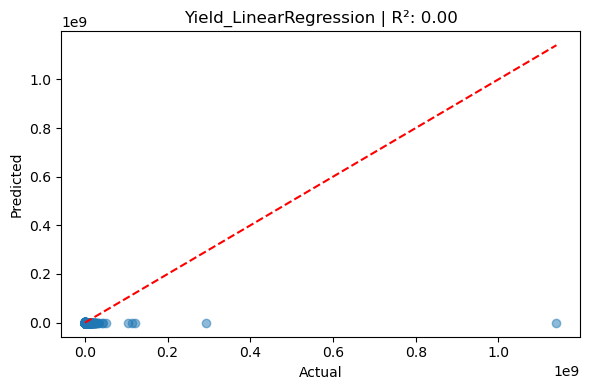

🔍 Evaluating: XGBoost
✅ MSE: 1136391495178.27 | R²: 0.91


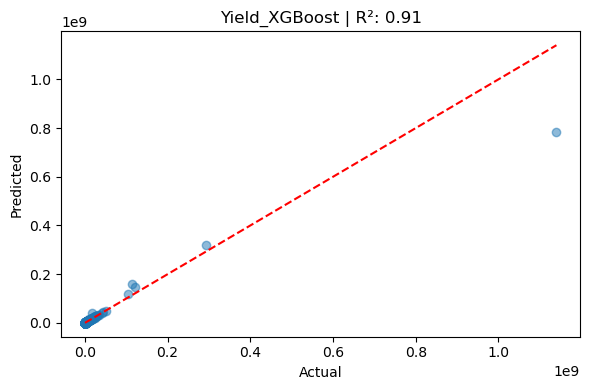


📊 All Evaluation Results:


,mse,r2
Production_RandomForest,3.844830e+11,0.999361
Area harvested_RandomForest,1.961079e+10,0.999081
Production_XGBoost,5.134983e+13,0.914616
Yield_XGBoost,1.136391e+12,0.909869
Area harvested_XGBoost,3.619418e+12,0.830444
Yield_RandomForest,2.792389e+12,0.778526
Area harvested_ANN,5.645393e+12,0.735535
Production_ANN,3.812916e+14,0.365993
Production_LinearRegression,3.905050e+14,0.350673
Area harvested_LinearRegression,1.390801e+13,0.348463


In [8]:
# Results container
evaluation_results = {}

# Evaluate each model for each target
for element in elements:
    print(f"\n📌 Evaluating Models for: {element}")

    # Define features dynamically
    feature_cols = [col for col in elements if col != element] + ["Year"]
    
    # Drop rows where *either* the target OR any feature is missing
    data = df.dropna(subset=[element] + feature_cols).copy()
    X = data[feature_cols]
    y = data[element]

    # Use DataFrame for consistency
    X = pd.DataFrame(X, columns=feature_cols)

    # Split before scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_names = ["ANN", "RandomForest", "LinearRegression", "XGBoost"]

    for model_name in model_names:
        print(f"🔍 Evaluating: {model_name}")
        model_key = f"{element}_{model_name}"

        try:
            if model_name == "ANN":
                model_path = f"../notebooks/models/{model_key}.h5"
                model = load_model(model_path, compile=False)

                # Load scaler separately
                scaler = joblib.load(f"../notebooks/models/{model_key}_scaler.pkl")
            else:
                bundle = joblib.load(f"../notebooks/models/{model_key}.pkl")
                model = bundle["model"]
                scaler = bundle["scaler"]

            # Apply scaler with correct column names
            X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

            if model_name == "ANN":
                y_pred = model.predict(X_test_scaled).flatten()
            else:
                y_pred = model.predict(X_test_scaled)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            evaluation_results[model_key] = {"mse": mse, "r2": r2}
            print(f"✅ MSE: {mse:.2f} | R²: {r2:.2f}")

            # Plot
            plt.figure(figsize=(6, 4))
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
            plt.title(f"{model_key} | R²: {r2:.2f}")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed to load or evaluate {model_key}: {e}")


# 📋 Display all results as DataFrame
results_df = pd.DataFrame.from_dict(evaluation_results, orient="index")
results_df = results_df.sort_values(by="r2", ascending=False)

print("\n📊 All Evaluation Results:")
display(results_df)